In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
import sys
sys.path.append('/Users/arthurbabey/Documents/master2/ML/road66/scripts')
from helpers import *

In [2]:
# Loaded a set of images
root_dir = "../Datasets/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = len(files) # Use all images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])



Loading 100 images
satImage_052.png
Loading 100 images
satImage_052.png


In [3]:
# 
# Preparation training data
# 


# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

# Extract features
#X2d = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
#X3d = np.asarray([ extract_features(img_patches[i]) for i in range(len(img_patches))])
#X_filter = np.asarray([ fanny_filter(img_patches[i]) for i in range(len(img_patches))])
#X = np.concatenate((X2d, X3d), axis = 1)
X = np.asarray([ extract_features(img_patches[i]) for i in range(len(img_patches))])

# Features augmentation 
X = poly_augmentation(X, 2)

# Extract labels
#foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])



In [4]:
# Print feature statistics

print('Computed ' + str(X.shape[0]) + ' features')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(np.max(Y)))  #TODO: fix, length(unique(Y)) 

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

Computed 62500 features
Feature dimension = 28
Number of classes = 1
Class 0: 46309 samples
Class 1: 16191 samples


In [5]:
# 
# Run logistic regression 
# 
# train a logistic regression classifier

from sklearn import linear_model

logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(X, Y)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [6]:
# 
# Ordering image
# 
root_testdir = "../Datasets/test_set_images"
test_names = os.listdir(root_testdir)

num_test = len(test_names)
order = [int(test_names[i].split("_")[1]) for i in range(num_test)]
index = np.argsort(order)

# Load image and reorder them
imgs_test = [load_image(os.path.join(root_testdir, test_names[i], test_names[i]) + ".png") for i in range(num_test)]
imgs_test = [imgs_test[i] for i in index]

# Crop images in patch and Linearize list of patches
patch_size = 16 # each patch is 16*16 pixels

img_patches_test = [img_crop(imgs_test[i], patch_size, patch_size) for i in range(num_test)]


# Linearize list of patches
img_patches_test = np.asarray([img_patches_test[i][j] for i in range(len(img_patches_test)) for j in range(len(img_patches_test[i]))])



# Extract, augment & standardize features
#X2dtest = np.asarray([ extract_features_2d(img_patches_test[i]) for i in range(len(img_patches_test))])
#X3dtest = np.asarray([ extract_features(img_patches_test[i]) for i in range(len(img_patches_test))])

#Xtest = np.concatenate((X2dtest, X3dtest), axis = 1)

Xtest = np.asarray([ extract_features(img_patches_test[i]) for i in range(len(img_patches_test))])

#features augmentation

Xtest = poly_augmentation(Xtest, 2)

# 
# Prediction 
# 

predictions = logreg.predict(Xtest)


# 
# Save prediction
# 
create_submission(predictions, "logreg_submission.csv")




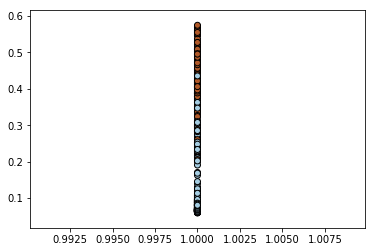

In [9]:
# Run prediction on the img_idx-th image
img_idx = 2

Xi = extract_img_features(image_dir + files[img_idx])
Xi = poly_augmentation(Xi, 2)
Zi = logreg.predict(Xi)

plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

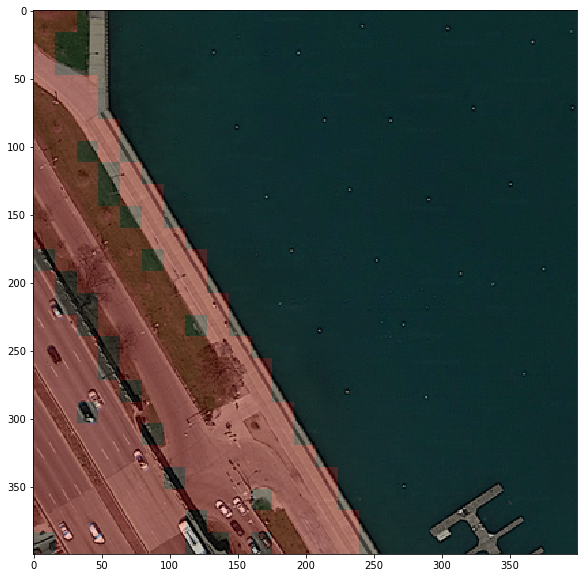

In [10]:
# Display prediction as an image
"""""
ca marche pas encore très bien.. ahah

"""""

img_idx = 2

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)